**MNIST/SVHN - DOMAIN ADAPTATION <br>
(version PYTORCH)**
---
PROJET COMPUTER VISION

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image

In [2]:
# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)    

device: cuda:0


In [3]:
# DOWNLOAD DATA 

# DOWNLOAD, RESIZE & NORMALIZE MNIST DATASET  (32x32x3 instead of originl 28x28x1)

from torchvision import datasets, transforms
import torch

# Define the transform to resize the image to 32x32 and replicate to 3 channels
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB by replicating channels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize each channel (assuming mean 0.5, std 0.5 for simplicity)
])

# Download and load the dataset with the defined transform
train_dataset_source = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset_source = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

# DOWNLOAD, (RESIZE &) NORMALISE, SVHN DATASET (Stret View House Numbers)
train_dataset_target = datasets.SVHN(root='./svhn_data/', split='train', transform=transform, download=True) # transform to insure same shape and normalisation
test_dataset_target = datasets.SVHN(root='./svhn_data/', split='test', transform=transform, download=True)


Using downloaded and verified file: ./svhn_data/train_32x32.mat
Using downloaded and verified file: ./svhn_data/test_32x32.mat


In [4]:

# Extract labels
Ys_train = train_dataset_source.targets.clone().detach()
Ys_test = test_dataset_source.targets.clone().detach()
Yt_train = torch.tensor(train_dataset_target.labels)
Yt_test = torch.tensor(test_dataset_target.labels)

# Calculate weights for the loss function
# Source domain (MNIST)
label_occurence_source = torch.bincount(Ys_train) 
weights_source = len(Ys_train) /  label_occurence_source
print('source (MNIST) labels occurence:', label_occurence_source)
print('source distribution (%):',torch.round(label_occurence_source/len(Ys_train)*100,decimals = 0))

# Target domain (SVHN)
label_occurence_target = torch.bincount(Yt_train)
weights_target = len(Yt_train) / label_occurence_target
print('target (SVHN) labels occurence:', label_occurence_target)
print('target distribution (%):',torch.round(label_occurence_target/len(Yt_train)*100,decimals = 0))

source (MNIST) labels occurence: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
source distribution (%): tensor([10., 11., 10., 10., 10.,  9., 10., 10., 10., 10.])
target (SVHN) labels occurence: tensor([ 4948, 13861, 10585,  8497,  7458,  6882,  5727,  5595,  5045,  4659])
target distribution (%): tensor([ 7., 19., 14., 12., 10.,  9.,  8.,  8.,  7.,  6.])


In [5]:
# Data Loader (Input Pipeline)
bs = 16 # batch size
source_loader_train = torch.utils.data.DataLoader(dataset=train_dataset_source, batch_size=bs, shuffle=True, drop_last=True)
source_loader_test = torch.utils.data.DataLoader(dataset=test_dataset_source, batch_size=bs, shuffle=False, drop_last=True)

target_loader_train = torch.utils.data.DataLoader(dataset=train_dataset_target, batch_size=bs, shuffle=True, drop_last=True)
target_loader_test = torch.utils.data.DataLoader(dataset=test_dataset_target, batch_size=bs, shuffle=False, drop_last=True)

**0/ Data exploration**
---

In [6]:
# DATASET STRUCTURE
print('train_dataset structure',dir(train_dataset_source))
print('train_dataset length:',len(train_dataset_source),type(train_dataset_source))
print('test_dataset length:',len(test_dataset_source),type(test_dataset_source))
print('images shape:',train_dataset_source[0][0].shape, type(train_dataset_source[0][0]))
labels = torch.unique(train_dataset_source.targets)
print('labels:', labels,type(train_dataset_source[0][1]), type(train_dataset_source.targets), type(train_dataset_source))

train_dataset structure ['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']
train_dataset length: 60000 <class 'torchvision.datasets.mnist.MNIST'>
test_dataset length

In [7]:
# CHECK ORGINAL DATASET FORMATS
#------------------------------

# MNIST dataset dimension
print('!!! Transformation for MNIST dataset only visible with the .item() method or, equivalently, in the dataloader !!!\n','!'*110)
print('dimension of X_train_source:',train_dataset_source.data.shape)
print('dimension of X_test_source:',test_dataset_source.data.shape)
mnist_data_train = train_dataset_source.data  # Convert to float for min/max calculation
print('MNIST data type:',type(mnist_data_train))
print('MNIST pixel value range (train):',mnist_data_train.float().min().item(),mnist_data_train.float().max().item())
mnist_data_test = test_dataset_source.data  # Convert to float for min/max calculation
print('MNIST pixel value range (test):',mnist_data_test.float().min().item(),mnist_data_test.float().max().item())

# SVHN dataset dimension
print('\ndimension of X_train_target:',train_dataset_target.data.shape)
print('dimension of X_test_target:',test_dataset_target.data.shape)
svhn_data_train = train_dataset_target.data#.float()  # Convert to float for min/max calculation
print('SVHN data type:',type(svhn_data_train))
print('SVHN pixel value range (train):',svhn_data_train.min().item(),svhn_data_train.max().item())
svhn_data_test = test_dataset_target.data#.float()  # Convert to float for min/max calculation
print('SVHN pixel value range (test):',svhn_data_test.min().item(),svhn_data_test.max().item())


!!! Transformation for MNIST dataset only visible with the .item() method or, equivalently, in the dataloader !!!
 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
dimension of X_train_source: torch.Size([60000, 28, 28])
dimension of X_test_source: torch.Size([10000, 28, 28])
MNIST data type: <class 'torch.Tensor'>


MNIST pixel value range (train): 0.0 255.0
MNIST pixel value range (test): 0.0 255.0

dimension of X_train_target: (73257, 3, 32, 32)
dimension of X_test_target: (26032, 3, 32, 32)
SVHN data type: <class 'numpy.ndarray'>
SVHN pixel value range (train): 0 255
SVHN pixel value range (test): 0 255


In [8]:
# Retrieve the first batch and check the dimensions

# MNIST
print('MNIST\ndimension of dataloader train (number of batches):',len(source_loader_train),type(source_loader_train  ))
print('dimension of dataloader test (number of batches):',len(source_loader_test),type(source_loader_test  ))
first_batch_data, first_batch_labels = next(iter(source_loader_train))

print('dimension of dataloader 1st batch for data:',first_batch_data.size(),type(first_batch_data))
print('data type:',type(first_batch_data[0,0,0,0].item()),'min:',first_batch_data.min().item(),'max:',first_batch_data.max().item())
print('dimension of dataloader 1st batch for labels:',first_batch_labels.size(),type(first_batch_labels))

# SVHN
print('\nSVHN\ndimension of dataloader train :',len(target_loader_train),type(target_loader_train  ))
print('dimension of dataloader test :',len(target_loader_test),type(target_loader_test  ))
first_batch_data, first_batch_labels = next(iter(target_loader_train))
print('dimension of dataloader 1st batch for data:',first_batch_data.size(),type(first_batch_data))
print('data type:',type(first_batch_data[0,0,0,0].item()),'min:',first_batch_data.min().item(),'max:',first_batch_data.max().item())
print('dimension of dataloader 1st batch for labels:',first_batch_labels.size(),type(first_batch_labels))

MNIST
dimension of dataloader train (number of batches): 3750 <class 'torch.utils.data.dataloader.DataLoader'>
dimension of dataloader test (number of batches): 625 <class 'torch.utils.data.dataloader.DataLoader'>
dimension of dataloader 1st batch for data: torch.Size([16, 3, 32, 32]) <class 'torch.Tensor'>
data type: <class 'float'> min: -1.0 max: 1.0
dimension of dataloader 1st batch for labels: torch.Size([16]) <class 'torch.Tensor'>

SVHN
dimension of dataloader train : 4578 <class 'torch.utils.data.dataloader.DataLoader'>
dimension of dataloader test : 1627 <class 'torch.utils.data.dataloader.DataLoader'>
dimension of dataloader 1st batch for data: torch.Size([16, 3, 32, 32]) <class 'torch.Tensor'>
data type: <class 'float'> min: -0.8745098114013672 max: 1.0
dimension of dataloader 1st batch for labels: torch.Size([16]) <class 'torch.Tensor'>


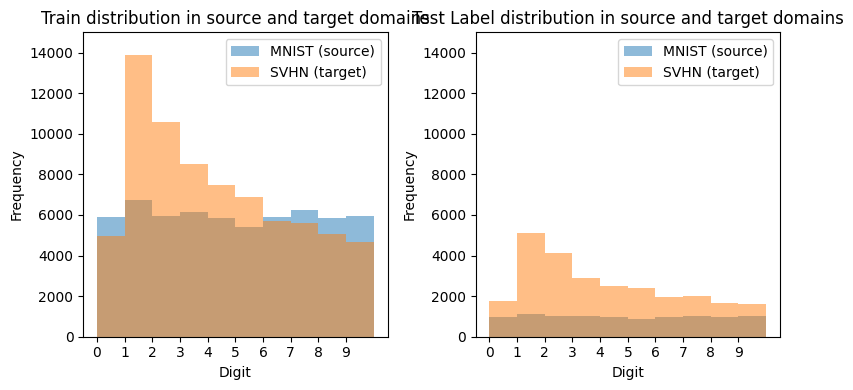

In [9]:
# SHOW TRAIN & TEST DISTRIBUTIONS
#--------------------------------

# Assuming Ys_train, Yt_train, Ys_test, and Yt_test are already defined
# Setup the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns figure

# Plot for train distributions
axs[0].hist(Ys_train.numpy(), bins=range(11), alpha=0.5, label='MNIST (source)')
axs[0].hist(Yt_train.numpy(), bins=range(11), alpha=0.5, label='SVHN (target)')
axs[0].set_xlabel('Digit')
axs[0].set_xticks(range(10))
axs[0].set_ylabel('Frequency')
axs[0].set_ylim([0, 15000])
axs[0].legend()
axs[0].set_title('Train distribution in source and target domains')

# Plot for test distributions
axs[1].hist(Ys_test.numpy(), bins=range(11), alpha=0.5, label='MNIST (source)')
axs[1].hist(Yt_test.numpy(), bins=range(11), alpha=0.5, label='SVHN (target)')
axs[1].set_xlabel('Digit')
axs[1].set_xticks(range(10))
axs[1].set_ylabel('Frequency')
axs[1].set_ylim([0, 15000])
axs[1].legend()
axs[1].set_title('Test Label distribution in source and target domains')

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the titles/labels
plt.show()


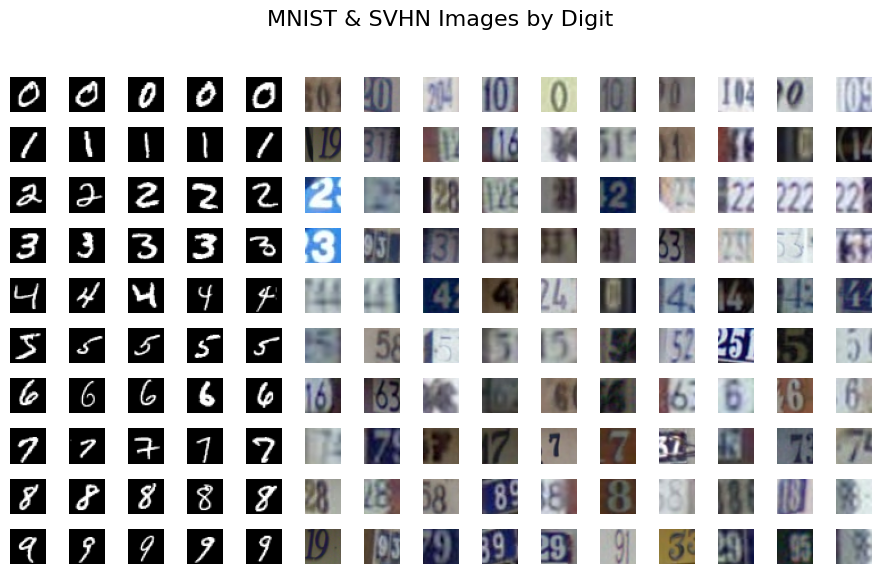

"\n    MNIST_i = source_loader_train.dataset.data[idx]\n    print(MNIST_i.shape, type(MNIST_i))\n    axs[i].imshow(MNIST_i.permute(1, 2, 0).numpy())\n    if i == 0 : axs[i].title.set_text('MNIST')\n    \n    # show 5 images with label i from SVHN\n    idx = (Yt_train == i).nonzero()[:5].squeeze()\n    SVHN_i = target_loader_train[idx]\n    axs[i+5].imshow(SVHN_i.permute(1, 2, 0).numpy())\n    if i == 5 : axs[i+5].title.set_text('SVHN')\n\nplt.show()\n"

In [10]:
# Visualise numbers from each dataset (first row of 1 : 5 MNIST images of 1, 5 SVHN images of 1, etc.)
#----------------------------------------------------------------------------------------------------

# MNIST
fig, axs = plt.subplots(10, 15, figsize=(9, 6))

for i in range(10):
    
    #show 5 images with label i from MNIST
    idx = (Ys_train == i).nonzero()[:5].squeeze()
        
    for j, index in enumerate(idx):
        # Access and prepare image
        image = train_dataset_source.data[index]
        axs[i, j].imshow(image, cmap='gray')
        axs[i,j].axis('off')

    idx = (Yt_train == i).nonzero()[:10].squeeze()

    for j, index in enumerate(idx):
        # Access and prepare image
        image = train_dataset_target.data[index]
        image=image.transpose((1, 2, 0))
        axs[i, 5+j].imshow(image)
        axs[i,5+j].axis('off')
    
fig.suptitle('MNIST & SVHN Images by Digit', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
'''
    MNIST_i = source_loader_train.dataset.data[idx]
    print(MNIST_i.shape, type(MNIST_i))
    axs[i].imshow(MNIST_i.permute(1, 2, 0).numpy())
    if i == 0 : axs[i].title.set_text('MNIST')
    
    # show 5 images with label i from SVHN
    idx = (Yt_train == i).nonzero()[:5].squeeze()
    SVHN_i = target_loader_train[idx]
    axs[i+5].imshow(SVHN_i.permute(1, 2, 0).numpy())
    if i == 5 : axs[i+5].title.set_text('SVHN')

plt.show()
'''


**1/ DANN (Domain Adversarial Neural Network)**
---
DANN is a model that can be used for domain adaptation. It is a neural network that is trained to predict the label of an image, while being invariant to the domain of the image. In this project, we will use the DANN model to adapt the MNIST dataset to the SVHN dataset.<br>

We will replicate the DANN mentionned in the Ganin et al. 2016 paper "Domain-Adversarial Training of Neural Networks" (https://arxiv.org/abs/1505.07818), with the Gradient Reversal Layer (GRL). 
It consists of the following architecture:<br>
- A feature extractor (CNN) that extracts features from the input image
- A label predictor (MLP) that predicts the label of the image
- A domain classifier (MLP) that predicts the domain of the image

For the layers, we use the architecture mentionned in the Ganin article for SVHN inspired Srivastava et al. 2014 paper, "Dropout: A Simple Way to Prevent Neural Networks from Overfitting" (https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf).<br>

*"The best architecture that we found uses three convolutional layers each followed by a max-pooling layer. The convolutional layers have 96, 128 and 256 filters respectively.
Each convolutional layer has a 5 × 5 receptive field applied with a stride of 1 pixel. Each max pooling layer pools 3 × 3 regions at strides of 2 pixels. The convolutional layers are followed by two fully connected hidden layers having 2048 units each. All units use the rectified linear activation function. Dropout was applied to all the layers of the network with the probability of retaining the unit being p = (0.9, 0.75, 0.75, 0.5, 0.5, 0.5) for the different layers of the network (going from input to convolutional layers to fully connected layers). In addition, the max-norm constraint with c = 4 was used for all the weights. A momentum of 0.95 was used in all the layers."*


In [11]:
######################################################################
# Class for Domain adversairial neural network (DANN)
# Create a DANN model inspired by the paper Srivatavas et al. (2014) on SVHN
######################################################################


# GRL - Gradient Reversal Layer
#------------------------------
# creation of a custom layer inheriting from nn.ModuleNotFoundError

class GradReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        alpha = ctx.alpha
        grad_input = grad_output.neg() * alpha
        return grad_input, None

class GradientReversalLayer(nn.Module):
    def __init__(self, alpha=1.0):
        super(GradientReversalLayer, self).__init__()
        self.alpha = alpha

    def forward(self, input):
        return GradReversal.apply(input, self.alpha)

# DANN model (based on Srivastavas et al. (2014))
#-------------------------------------------------

class DANN_Srivastavas(nn.Module):

    def __init__(self, alpha=0.0001):
        super(DANN_Srivastavas, self).__init__()
        
        # Convolutional layers with padding
        self.conv1 = nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(96, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Fully connected layers for the main task
        self.fc1_main = nn.Linear(256 * 3 * 3, 2048)  # Adjusted based on feature map size
        self.fc2_main = nn.Linear(2048, 2048)
        self.fc3_main = nn.Linear(2048, 10)
        
        # Fully connected layers for the domain classifier task
        self.fc1_domain = nn.Linear(256 * 3 * 3, 2048)  # Adjusted based on feature map size
        self.fc2_domain = nn.Linear(2048, 1)
        
        # Gradient Reversal Layer
        self.grl = GradientReversalLayer(alpha=alpha)

        # Dropout layers
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.5)

    '''def forward(self, class_data, domain_data):
    
        # Split combined_data into src_data and tgt_data
        #half_size = x.size(0) // 2
        #source_data = x[:half_size]

        # Forward pass for source data
        class_x = F.relu(self.pool(self.conv1(class_data)))
        class_x = self.dropout1(class_x)
        class_x = F.relu(self.pool(self.conv2(class_x)))
        class_x = self.dropout2(class_x)
        class_x = F.relu(self.pool(self.conv3(class_x)))
        class_x = self.dropout3(class_x)
        class_x = class_x.view(-1, 256 * 3 * 3)
        class_x = self.dropout4(F.relu(self.fc1_main(class_x)))
        class_x = self.dropout5(F.relu(self.fc2_main(class_x)))
        main_class_output = self.fc3_main(class_x)

        # Forward pass for target data
        domain_x = F.relu(self.pool(self.conv1(domain_data)))
        domain_x = self.dropout1(domain_x)
        domain_x = F.relu(self.pool(self.conv2(domain_x)))
        domain_x = self.dropout2(domain_x)
        domain_x = F.relu(self.pool(self.conv3(domain_x)))
        domain_x = self.dropout3(domain_x)
        domain_x = domain_x.view(-1, 256 * 3 * 3)
        domain_x = self.grl(domain_x)
        domain_x = domain_x.view(-1, 256 * 3 * 3)
        domain_x = self.dropout6(F.relu(self.fc1_domain(domain_x)))
        domain_class_output = torch.sigmoid(self.fc2_domain(domain_x))

        return main_class_output, domain_class_output
'''

    def forward(self, class_data, domain_data=None):
        # Compute shared convolutional and pooling operations once
        output_features = F.relu(self.pool(self.conv1(class_data)))
        output_features = self.dropout1(output_features)
        output_features = F.relu(self.pool(self.conv2(output_features)))
        output_features = self.dropout2(output_features)
        output_features = F.relu(self.pool(self.conv3(output_features)))
        output_features = self.dropout3(output_features)

        # Forward pass for source data
        class_x = output_features.view(-1, 256 * 3 * 3)
        class_x = self.dropout4(F.relu(self.fc1_main(class_x)))
        class_x = self.dropout5(F.relu(self.fc2_main(class_x)))
        main_class_output = self.fc3_main(class_x)

        # Determine if separate domain data processing is required
        if domain_data is not None and class_data is not domain_data:
            # Compute convolutional and pooling operations for domain_data
            domain_x = F.relu(self.pool(self.conv1(domain_data)))
            domain_x = self.dropout1(domain_x)
            domain_x = F.relu(self.pool(self.conv2(domain_x)))
            domain_x = self.dropout2(domain_x)
            domain_x = F.relu(self.pool(self.conv3(domain_x)))
            output_features = self.dropout3(domain_x)

        # Forward pass for domain data
        domain_x = output_features.view(-1, 256 * 3 * 3)
        domain_x = self.grl(domain_x)
        domain_x = self.dropout6(F.relu(self.fc1_domain(domain_x)))
        domain_class_output = torch.sigmoid(self.fc2_domain(domain_x))

        return main_class_output, domain_class_output

#  Define evaluation function
#----------------------------

def evaluate(model, class_loader, domain_loader=None, mode='Test'):
    model.eval()  # Switch to evaluation mode
    
    # Initialize lists to collect predictions
    y_pred_class = []
    y_pred_domain = []
    
    # Initialize counters
    class_correct, domain_correct, class_samples, domain_samples = 0, 0, 0, 0
    
    with torch.no_grad():
        if domain_loader is None or class_loader is domain_loader:
            for data, labels in class_loader:
                data, labels = data.to(device), labels.to(device)
                class_output, domain_output = model(data)
                
                class_correct += (class_output.argmax(1) == labels).sum().item()
                class_samples += labels.size(0)
                
                domain_labels = torch.ones(data.size(0), 1, device=device)  # Assumes target=1
                print("Shapes: domain_output:", domain_output.shape, "domain_labels:", domain_labels.shape)
                print("Types: domain_output:", domain_output.dtype, "domain_labels:", domain_labels.dtype)
                domain_output = domain_output.squeeze()
                y_pred_domain_batch = (domain_output > 0.5).int().squeeze().tolist()
                print("Shapes: domain_output:", domain_output.shape, "domain_labels:", domain_labels.shape)
                print("Types: domain_output:", domain_output.dtype, "domain_labels:", domain_labels.dtype)
                domain_correct += (y_pred_domain_batch == domain_labels).sum().item()
                domain_samples += domain_labels.size(0)
                
                # Collect predictions
                y_pred_class.extend(class_output.argmax(1).tolist())
                y_pred_domain.extend((domain_output > 0.5).float().squeeze().tolist())
        else:
            for data, labels in class_loader:
                data, labels = data.to(device), labels.to(device)
                class_output, _ = model(data, data)
                class_correct += (class_output.argmax(1) == labels).sum().item()
                class_samples += labels.size(0)
                y_pred_class.extend(class_output.argmax(1).tolist())
                
            for data, _ in domain_loader:
                data = data.to(device)
                _, domain_output = model(data, data)
                domain_labels = torch.ones(data.size(0), 1, device=device)
                domain_correct += (domain_output > 0.5 == domain_labels.bool()).sum().item()
                domain_samples += domain_labels.size(0)
                y_pred_domain.extend((domain_output > 0.5).float().squeeze().tolist())
                
        print(f'{mode} Classification Accuracy: {100 * class_correct / class_samples:.2f}%')
        print(f'{mode} Domain Classification Accuracy: {100 * domain_correct / domain_samples:.2f}%')

    model.train()  # Switch back to training mode
    
    # Convert lists to tensors for return
    y_pred_class = torch.tensor(y_pred_class, device=device)
    y_pred_domain = torch.tensor(y_pred_domain, device=device)
    
    return y_pred_class, y_pred_domain

'''    
def evaluate(model, class_loader, domain_loader, mode='Test'):
    model.eval()  # Switch to evaluation mode
    
    with torch.no_grad():
        # Initialize counters for accuracy calculations
        total_class_correct = 0
        total_domain_correct = 0
        total_samples = 0
        total_domain_samples = 0

        # Loop over source data for classification accuracy
        for src_data, src_label in class_loader:
            src_data, src_label = src_data.to(device), src_label.to(device)
            
            class_output, _ = model(src_data, src_data)
            _, predicted_labels = torch.max(class_output, 1)
            total_class_correct += (predicted_labels == src_label).sum().item()
            total_samples += src_label.size(0)

        # Assuming target_loader has the same structure as source_loader
        for tgt_data, _ in domain_loader:
            tgt_data = tgt_data.to(device)
            _, domain_output = model(tgt_data, tgt_data)
            domain_labels = torch.ones(tgt_data.size(0), 1, device=device)  # Target=1
            predicted_domain = domain_output > 0.5
            total_domain_correct += (predicted_domain == domain_labels).sum().item()
            total_domain_samples += domain_labels.size(0)
        
        class_accuracy = 100 * total_class_correct / total_samples
        domain_accuracy = 100 * total_domain_correct / total_domain_samples

        print(f'{mode} Classification Accuracy: {class_accuracy:.2f}%')
        print(f'{mode} Domain Classification Accuracy: {domain_accuracy:.2f}%')

    model.train()  # Switch back to training mode
'''

# Define the train function
#--------------------------

def train(model, source_loader, target_loader, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    
    for epoch in range(num_epochs):
        len_dataloader = min(len(source_loader), len(target_loader))
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        
        # Initialize counters for accuracy calculations
        total_class_correct = 0
        total_domain_correct = 0
        total_samples = 0
        total_domain_samples = 0

        for i in range(len_dataloader):

            # Load a batch from the source domain
            src_data, src_label = next(source_iter)
            src_data, src_label = src_data.to(device), src_label.to(device)
            
            # Load a batch from the target domain
            tgt_data, _ = next(target_iter)
            tgt_data = tgt_data.to(device)
            
            # Ensure matching batch sizes
            if src_data.size(0) != tgt_data.size(0):
                print(f"Skipping batch due to mismatched sizes: source ({src_data.size(0)}) vs target ({tgt_data.size(0)})")
                continue

            # Reset gradients
            optimizer.zero_grad()
            
            # new
            combined_data = torch.cat([src_data, tgt_data], 0)
            domain_label = torch.zeros((src_data.size(0) + tgt_data.size(0), 1), device=device) # creating a tensor of zeros of good size
            domain_label[:src_data.size(0)] = 1  # Assigning 1 for MNIST so that source=1, target=0

            class_output, domain_output = model(tgt_data , combined_data)
            class_loss = nn.CrossEntropyLoss()(class_output, src_label)
            domain_output = nn.Sigmoid()(domain_output) # Sigmoid activation for binary classification
            domain_loss = nn.BCELoss()(domain_output, domain_label)
            
            # Total loss
            total_loss = class_loss + domain_loss
            
            # Backpropagation
            total_loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted_labels = torch.max(class_output, 1)
            total_class_correct += (predicted_labels == src_label).sum().item()
            total_samples += src_label.size(0)

            predicted_domain = domain_output > 0.5
            total_domain_correct += (predicted_domain == domain_label).sum().item()
            total_domain_samples += domain_label.size(0)

            if (i + 1) % 100 == 0:
                class_accuracy = 100 * total_class_correct / total_samples
                domain_accuracy = 100 * total_domain_correct / total_domain_samples
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len_dataloader}], Class Loss: {class_loss.item()}, Domain Loss: {domain_loss.item()}, Class Accuracy: {class_accuracy:.2f}%, Domain Accuracy: {domain_accuracy:.2f}%')
                
                # Initialize counters for next 100 accuracy calculations
                total_class_correct = 0
                total_domain_correct = 0
                total_samples = 0
                total_domain_samples = 0
                
        # Evaluate the model on the test set after an epoch of training

        print(f'Epoch {epoch+1} complete. Evaluating...')
        
        # Evaluate on training data
        print('Evaluating on source training data')
        #y_pred_train , y_pred_domain_train = evaluate(model, source_loader_train, target_loader_train, mode='Train')
        
        # Evaluate on test data
        print('Evaluating on source test data')
        #y_pred_test , y_pred_domain_test = evaluate(model, source_loader_test, target_loader_test, mode='Test')

        #return predictions if last epoch

        # Switch back to training mode if you continue training
        model.train()

    #return predictions after last epoch           
    #return y_pred_train, y_pred_domain_train, y_pred_test, y_pred_domain_test
        





In [12]:
#################################################################
# INSTANTIATE AND TRAIN THE MODEL
#################################################################

# Choose parameters
#----------------------
alpha = 0  # adjust as needed for DANN to learn
lr = 0.5  # Learning rate
num_epochs = 1  # Number of epochs to train for

# Model setup
#--------------------------
model = DANN_Srivastavas(alpha).to(device)
optimizer = optim.Adam(model.parameters(), lr)

# Start training
#---------------
train(model, source_loader_train, target_loader_train, optimizer, num_epochs)

Epoch [1/1], Step [100/3750], Class Loss: 11.560306549072266, Domain Loss: 0.8132616281509399, Class Accuracy: 10.06%, Domain Accuracy: 50.00%
Epoch [1/1], Step [200/3750], Class Loss: 2.5852468013763428, Domain Loss: 0.8132616281509399, Class Accuracy: 10.06%, Domain Accuracy: 50.00%
Epoch [1/1], Step [300/3750], Class Loss: 2.4248428344726562, Domain Loss: 0.8132616281509399, Class Accuracy: 10.75%, Domain Accuracy: 50.00%
Epoch [1/1], Step [400/3750], Class Loss: 2.4131383895874023, Domain Loss: 0.8132616281509399, Class Accuracy: 11.06%, Domain Accuracy: 50.00%
Epoch [1/1], Step [500/3750], Class Loss: 11398366208.0, Domain Loss: 0.8132616281509399, Class Accuracy: 10.75%, Domain Accuracy: 50.00%
Epoch [1/1], Step [600/3750], Class Loss: 2.3169162273406982, Domain Loss: 0.8132616281509399, Class Accuracy: 10.12%, Domain Accuracy: 50.00%
Epoch [1/1], Step [700/3750], Class Loss: 2.455709218978882, Domain Loss: 0.8132616281509399, Class Accuracy: 9.81%, Domain Accuracy: 50.00%
Epoch 

In [14]:
# Evaluate the model
#---------------------

# SOURCE DATASET
print('EVALUATION ON SOURCE DATASET')
# Evaluate on training data
print('Evaluating on source training data')
evaluate(model, source_loader_train, source_loader_train, mode='Train')

'''# Evaluate on test data
print('Evaluating on source test data')
evaluate(model, source_loader_test, source_loader_test, mode='Test')

# TARGET DATASET
print('\nEVALUATION ON TARGET DATASET')
# Evaluate on target data
print('Evaluating on target data')
evaluate(model, target_loader_train, target_loader_train, mode='Train')

# Evaluate on test data
print('Evaluating on target test data')
evaluate(model, target_loader_test, target_loader_test, mode='Test')

# Save the model
#----------------
torch.save(model.state_dict(), 'dann_svhn.pth')'''



EVALUATION ON SOURCE DATASET
Evaluating on source training data
Shapes: domain_output: torch.Size([16, 1]) domain_labels: torch.Size([16, 1])
Types: domain_output: torch.float32 domain_labels: torch.float32
Shapes: domain_output: torch.Size([16]) domain_labels: torch.Size([16, 1])
Types: domain_output: torch.float32 domain_labels: torch.float32


AttributeError: 'bool' object has no attribute 'sum'

In [ ]:
# Instantiate your model
model = DANN_Srivastavas()

# Load the saved state
model.load_state_dict(torch.load('dann_svhn.pth'))
model.eval()  # Set the model to evaluation mode

# Run evaluation on source_loader_test
evaluate(model, source_loader_test)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same